# Structured data learning with Wide, Deep, and Cross networks


## The dataset

This example uses the [Covertype](https://archive.ics.uci.edu/ml/datasets/covertype) dataset from the UCI
Machine Learning Repository. The task is to predict forest cover type from cartographic variables.
The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2
categorical features. Each instance is categorized into 1 of 7 classes.

## Setup

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [2]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


The two categorical features in the dataset are binary-encoded.
We will convert this dataset representation to the typical representation, where each
categorical feature is represented as a single integer value.

In [4]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


The shape of the DataFrame shows there are 13 columns per sample
(12 for the features and 1 for the target label).

Let's split the data into training (85%) and test (15%) sets.

In [5]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494093
Test split size: 86919


Next, store the training and test data in separate CSV files.

In [6]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

In [7]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

## Experiment setup

Next, let's define an input function that reads and parses the file, then converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [ ]:

def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


Here we configure the parameters and implement the procedure for running a training and
evaluation experiment given a model.

In [ ]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


## Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

In [ ]:

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


## Encode features

We create two representations of our input features: sparse and dense:
1. In the **sparse** representation, the categorical features are encoded with one-hot
encoding using the `CategoryEncoding` layer. This representation can be useful for the
model to *memorize* particular feature values to make certain predictions.
2. In the **dense** representation, the categorical features are encoded with
low-dimensional embeddings using the `Embedding` layer. This representation helps
the model to *generalize* well to unseen feature combinations.

In [8]:

from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features


## Experiment 1: a baseline model

In the first experiment, let's create a multi-layer feed-forward network,
where the categorical features are one-hot encoded.

In [9]:

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

NameError: ignored

Let's run it:

In [ ]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 17s 8ms/step - loss: 0.7648 - sparse_categorical_accuracy: 0.6817
Epoch 2/50
1864/1864 [==============================] - 8s 4ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.7136
Epoch 3/50
1864/1864 [==============================] - 8s 4ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.7246
Epoch 4/50
1864/1864 [==============================] - 8s 4ms/step - loss: 0.6169 - sparse_categorical_accuracy: 0.7350
Epoch 5/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.6047 - sparse_categorical_accuracy: 0.7400
Epoch 6/50
1864/1864 [==============================] - 8s 4ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.7433
Epoch 7/50
1864/1864 [==============================] - 8s 4ms/step - loss: 0.5917 - sparse_categorical_accuracy: 0.7460
Epoch 8/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.7490
Epo

The baseline linear model achieves ~76% test accuracy.

## Experiment 2: Wide & Deep model

In the second experiment, we create a Wide & Deep model. The wide part of the model
a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the
dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different
representations.

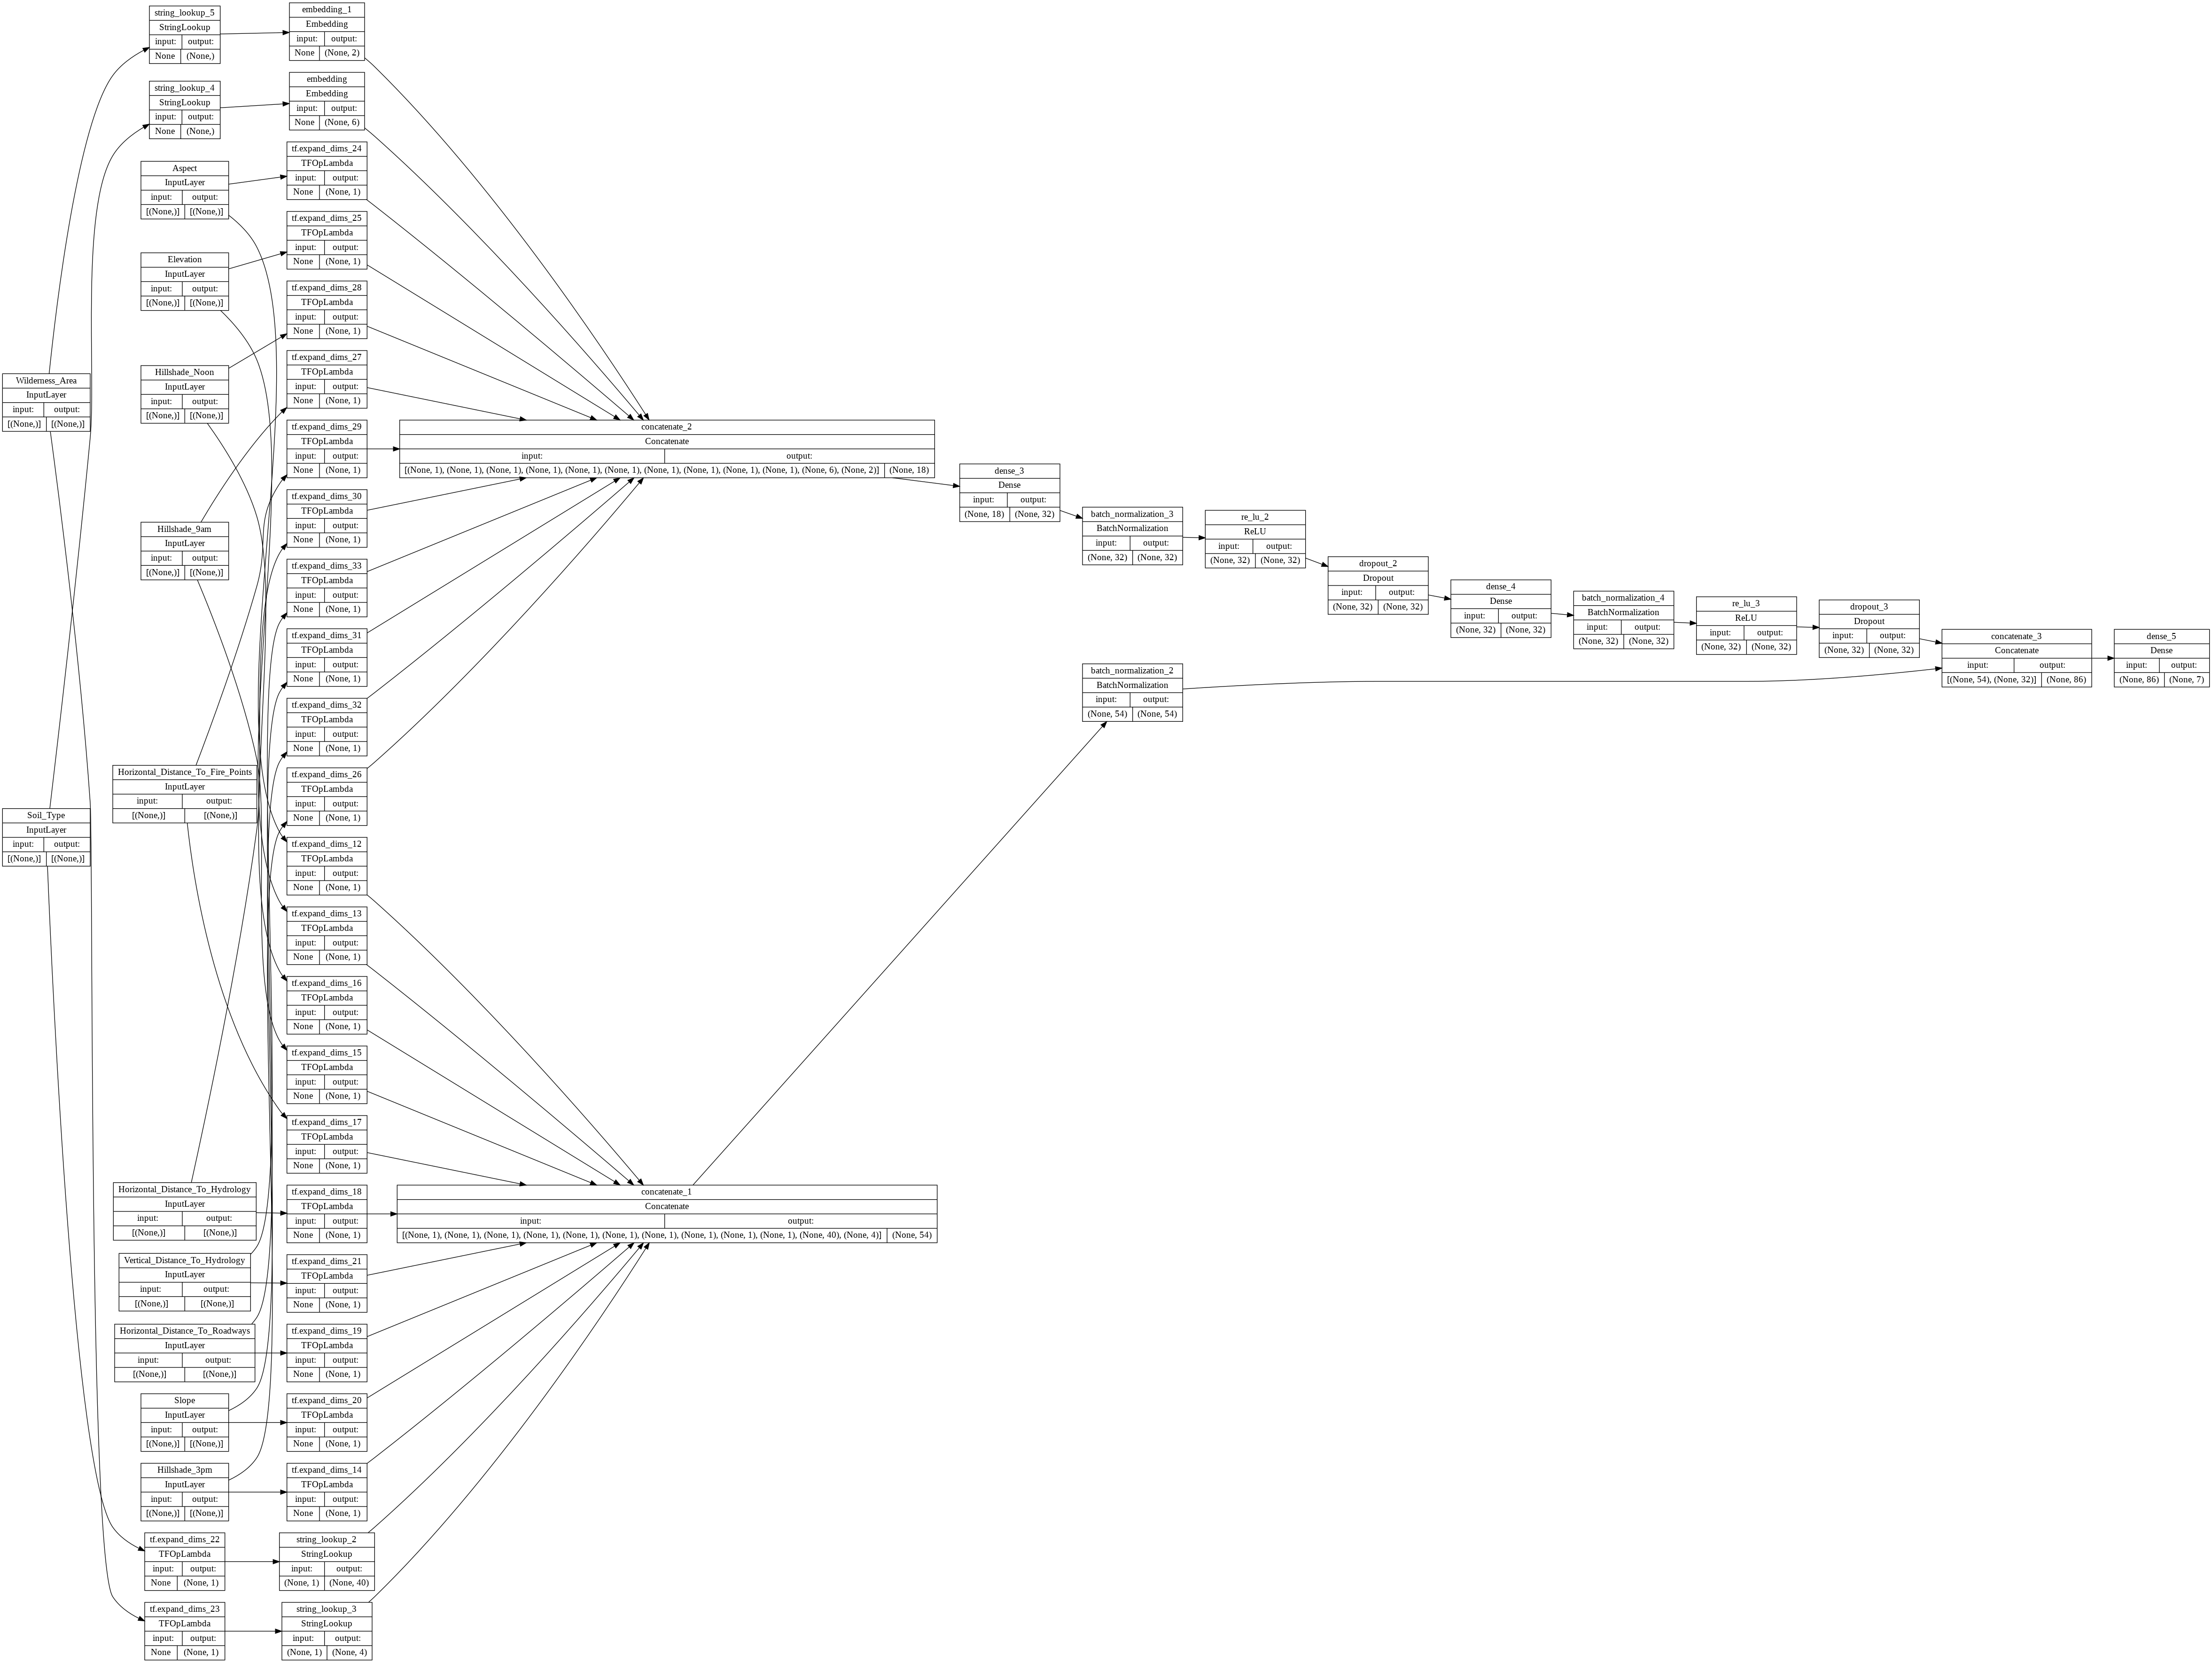

In [ ]:

def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 19s 9ms/step - loss: 0.7100 - sparse_categorical_accuracy: 0.7036
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6069 - sparse_categorical_accuracy: 0.7365
Epoch 3/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5884 - sparse_categorical_accuracy: 0.7434
Epoch 4/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5755 - sparse_categorical_accuracy: 0.7493
Epoch 5/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5665 - sparse_categorical_accuracy: 0.7540
Epoch 6/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.7566
Epoch 7/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5549 - sparse_categorical_accuracy: 0.7592
Epoch 8/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.7

The wide and deep model achieves ~79% test accuracy.

## Experiment 3: Deep & Cross model

In the third experiment, we create a Deep & Cross model. The deep part of this model
is the same as the deep part created in the previous experiment. The key idea of
the cross part is to apply explicit feature crossing in an efficient way,
where the degree of cross features grows with layer depth.

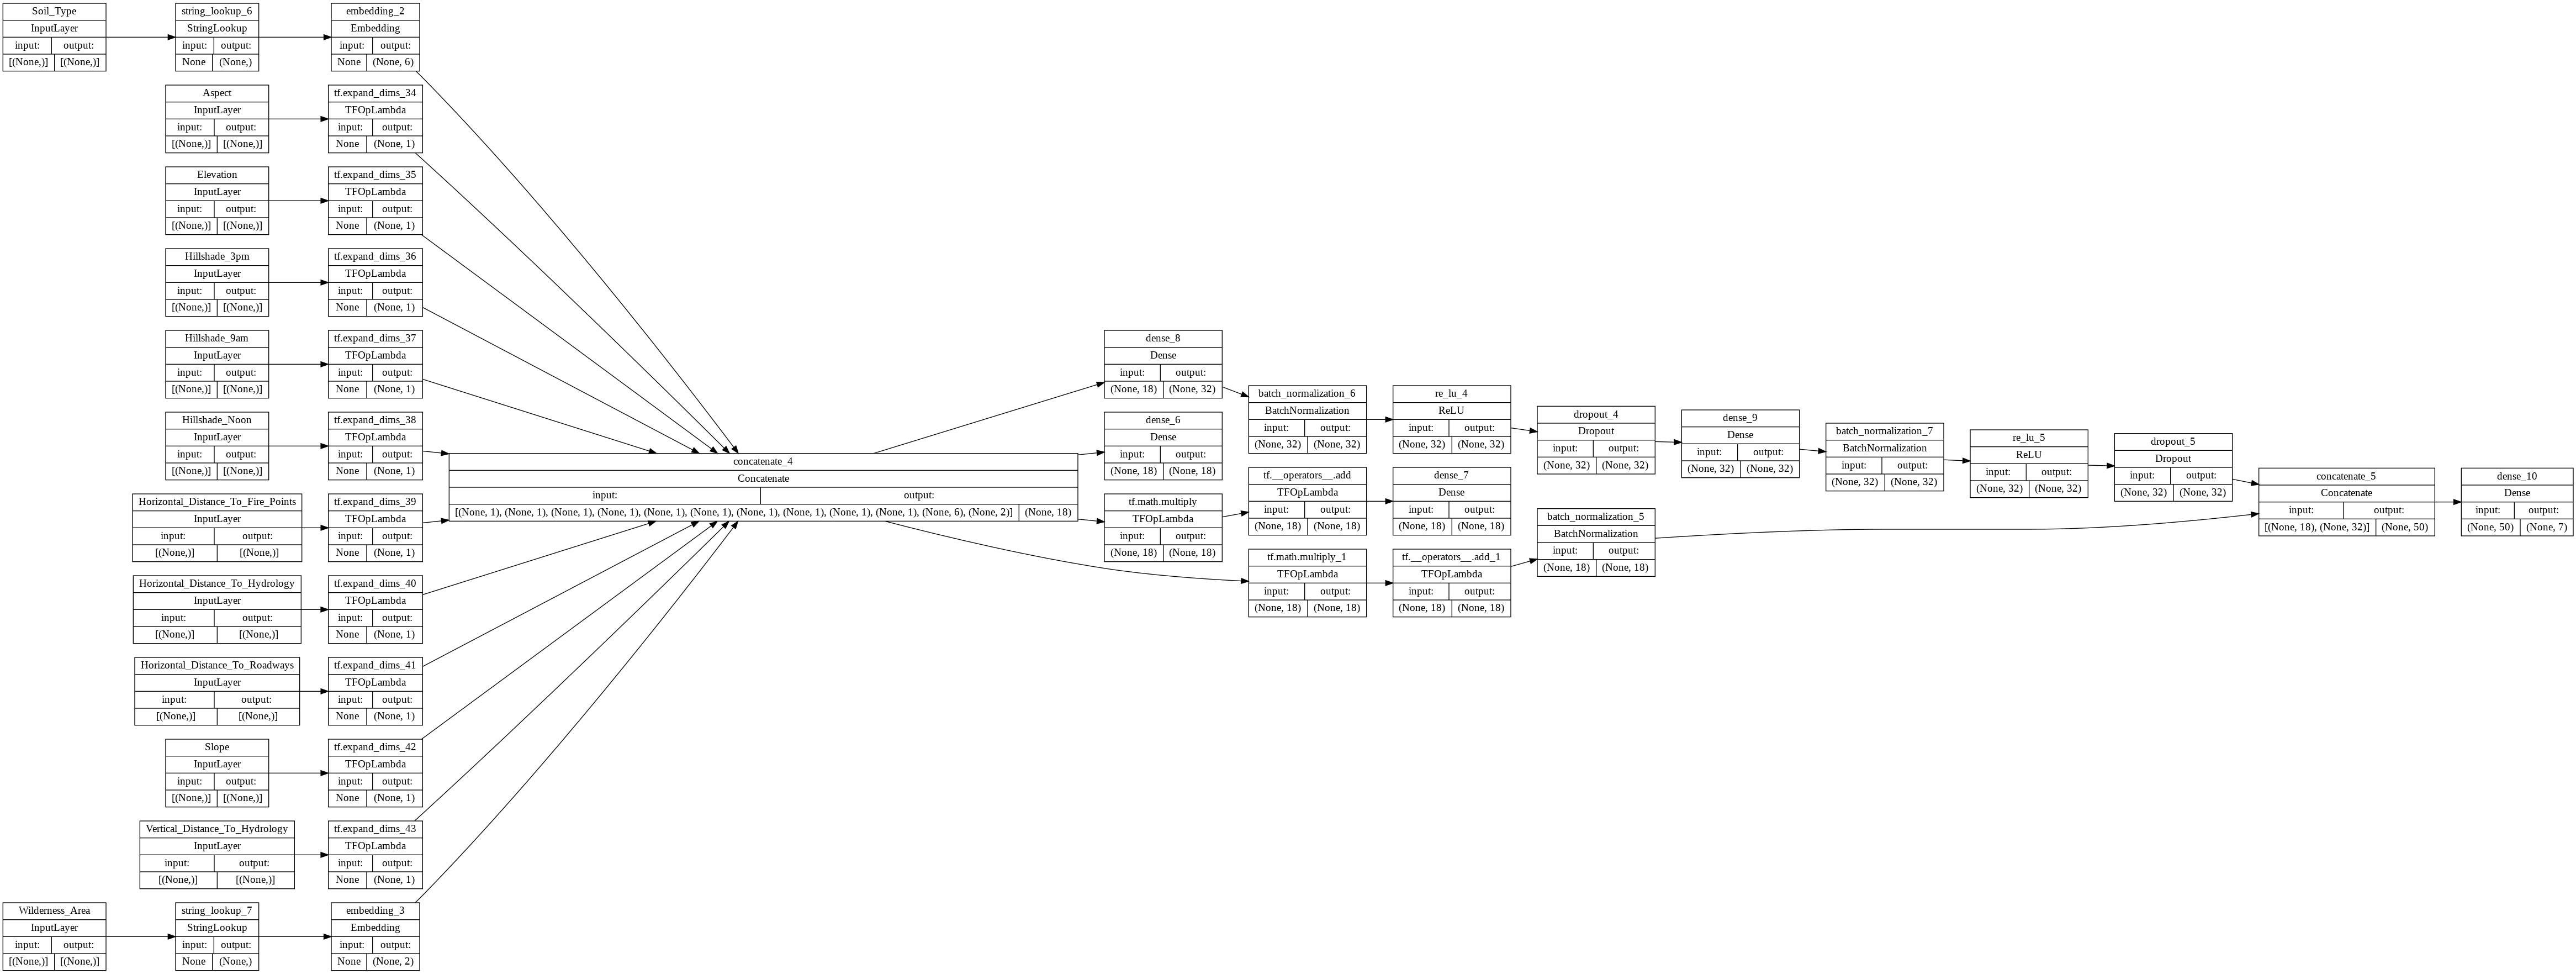

In [ ]:

def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 18s 9ms/step - loss: 0.6973 - sparse_categorical_accuracy: 0.7099
Epoch 2/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.7458
Epoch 3/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5736 - sparse_categorical_accuracy: 0.7531
Epoch 4/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5616 - sparse_categorical_accuracy: 0.7581
Epoch 5/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5540 - sparse_categorical_accuracy: 0.7602
Epoch 6/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.7630
Epoch 7/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5416 - sparse_categorical_accuracy: 0.7651
Epoch 8/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5374 - sparse_categorical_accuracy: 0.7670


The deep and cross model achieves ~81% test accuracy.

## Conclusion

You can use Keras Preprocessing Layers to easily handle categorical features
with different encoding mechanisms, including one-hot encoding and feature embedding.
In addition, different model architectures — like wide, deep, and cross networks
— have different advantages, with respect to different dataset properties.
You can explore using them independently or combining them to achieve the best result
for your dataset.